Predicted probabilities for the first 5 examples:
 [[0.15301974 0.84698026]
 [0.72028516 0.27971484]
 [0.05358372 0.94641628]
 [0.46517875 0.53482125]
 [0.0013241  0.9986759 ]]
y_pred: [1 0 1 1 1]
y_test: [1 1 1 1 1]
Accuracy: 81.40%


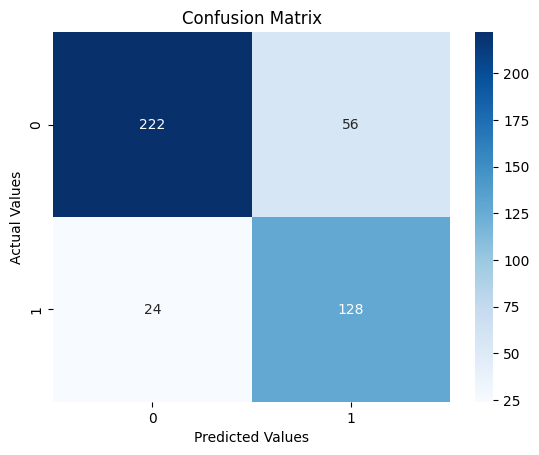

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430



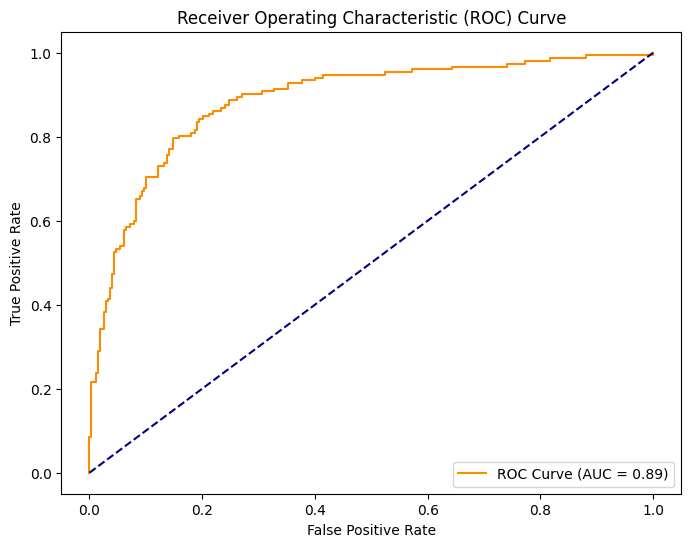

KeyError: "None of [Index([ 13.29721772827684,  4.542523817722191,  19.55508452555359,\n       12.209265546203785,  18.45435609061961,  4.140143784276235,\n       0.6460472705489217, 13.723825705512622, 12.167847629604712,\n        16.02868823659191,\n       ...\n        2.982747140176412,  7.770687451209335,  19.39176610213685,\n        4.089458262968291,   9.30870649975102, 1.5611257867953587,\n        18.76726065522721,  4.594670177230455,  8.674505178970971,\n        7.890703150840494],\n      dtype='float64', length=2149)] are in the [columns]"

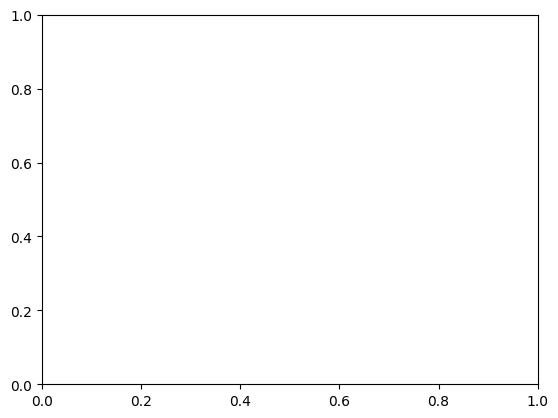

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
#print(os.getcwd())

#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')


#%run NeuroCurveImports.py
#%run pre_process.py
#%run setup.py
#%run firstgraph.py

#from setup import *
#from firstgraph import *
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
#loadup()
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')
''' ----------- Preprocessing ----------- '''
X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

''' Handle categorical variables '''
categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

''' ----------- Model Training ----------- '''
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

''' ----------- Evaluation ----------- '''
y_prob = model.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob[:5])

y_pred = model.predict(X_test)
print(f"y_pred: {y_pred[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

''' ROC Curve '''
y_prob_class1 = y_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_class1)
roc_auc = roc_auc_score(y_test, y_prob_class1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


"""
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
"""

x = NeuroCurveOG['AlcoholConsumption']
y = NeuroCurveOG['Diagnosis']

#NeuroCurveOG.plot(kind="scatter", x=x, y=y, alpha=0.2)
plt.show